
$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [99]:
g = dataset[0]
print(f"Number of nodes: {g.num_nodes}")
print(f"Number of edges: {g.num_edges}")
print(f"Number of training nodes: {g.train_mask.sum()}")
print(g.train_mask)
print(f"Has isolated nodes: {g.has_isolated_nodes()}")
print(f"Has self-loops: {g.has_self_loops()}")
print(f"Is undirected: {g.is_undirected()}")
print(f"Property: {g.keys()}")

Number of nodes: 34
Number of edges: 156
Number of training nodes: 4
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Property: ['train_mask', 'y', 'edge_index', 'x']


In [4]:
# 34个节点，维度为34，有label y，
print(g)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [5]:
edge_idx = g.edge_index
# coo format，用于表示稀疏矩阵
# pyg和dgl一样都是将无向图视作特殊的有向图
print(edge_idx.T[:5, :])

tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5]])


In [110]:
import os

import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=False,
        node_color=color,
        cmap="Set2",
    )
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f"Epoch: {epoch}, Loss: {loss.item():.4f}", fontsize=16)
    plt.show()

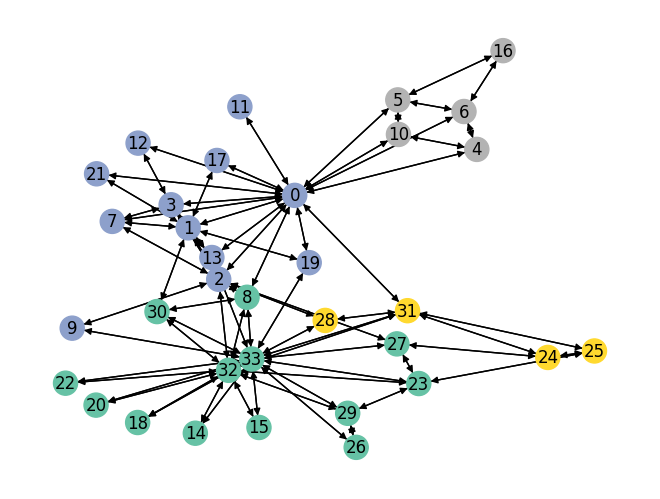

In [77]:
nxg = to_networkx(g)
nx.draw(
    nxg,
    pos=nx.spring_layout(nxg, seed=42),
    with_labels=True,
    node_color=g.y,
    cmap="Set2",
)

## Implementing Graph Neural Networks

After learning about PyG's data handling, it's time to implement our first Graph Neural Network!

For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

```python
GCNConv.forward(
    self,<>
    x: torch.Tensor,
    edge_index: Union[torch.Tensor, torch_sparse.tensor.SparseTensor],
    edge_weight: Union[torch.Tensor, NoneType] = None,
) -> torch.Tensor
```

In [91]:
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv

in_feats = dataset.num_features
out_feats = dataset.num_classes


class GCN(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(in_feats, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, out_feats)

    def forward(self, x, edge_idx):
        h = self.conv1(x, edge_idx)
        h = h.tanh()
        h = self.conv2(h, edge_idx)
        h = h.tanh()
        h = self.conv3(h, edge_idx)
        h = h.tanh()
        out = self.classifier(h)
        return out, h  # 输出分类 和 特征h

In [92]:
gcn = GCN(in_feats, out_feats)
gcn

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

In [93]:
logits, h = gcn(g.x, g.edge_index)
h = h.detach()
print(logits.shape)
print(h.shape)

torch.Size([34, 4])
torch.Size([34, 2])


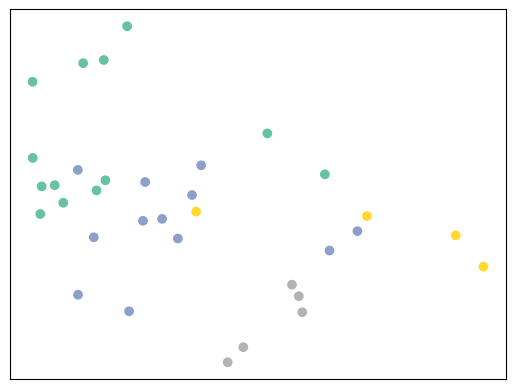

In [94]:
# plt.figure(figsize=(4,4))
plt.scatter(h[:, 0], h[:, 1], c=g.y, cmap="Set2")
plt.xticks([])
plt.yticks([])
plt.show()

In [123]:
device = "cuda"

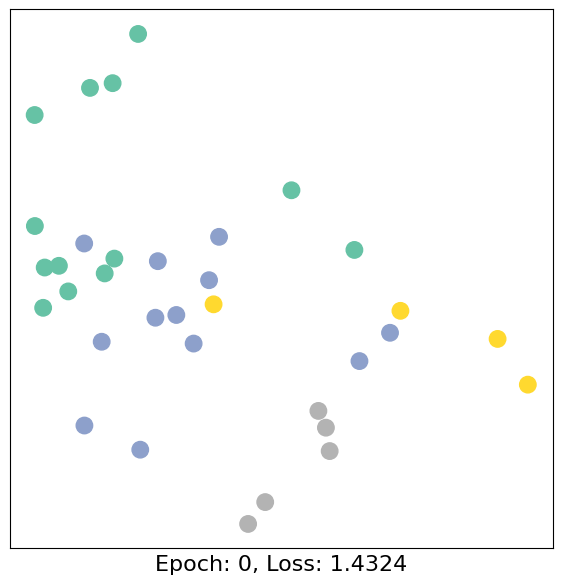

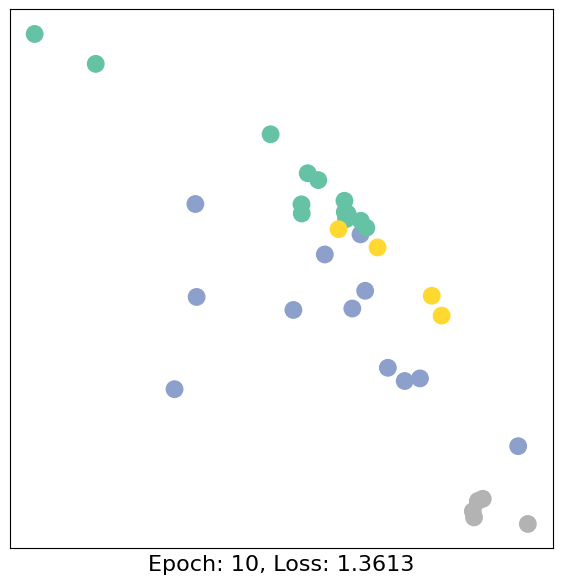

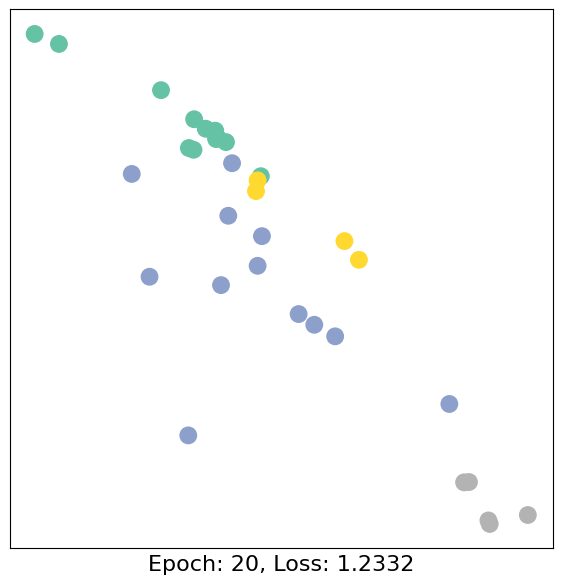

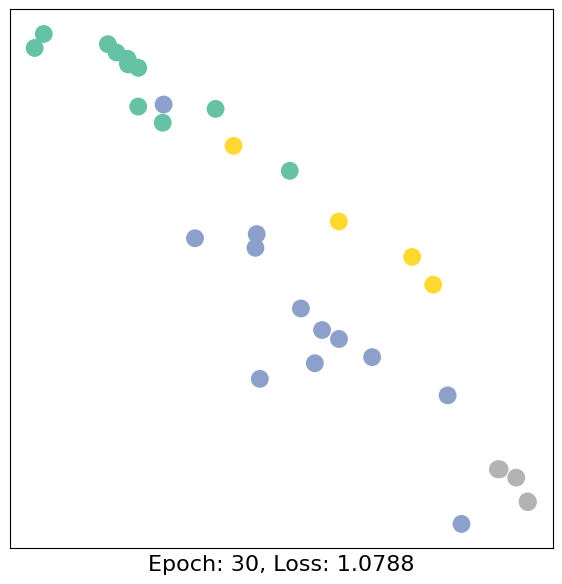

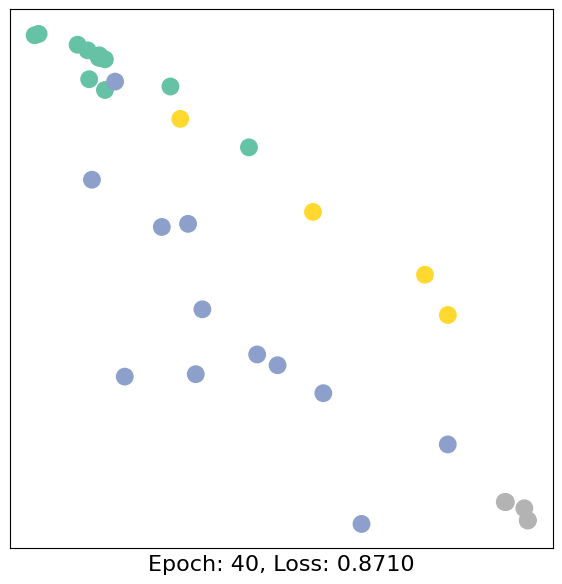

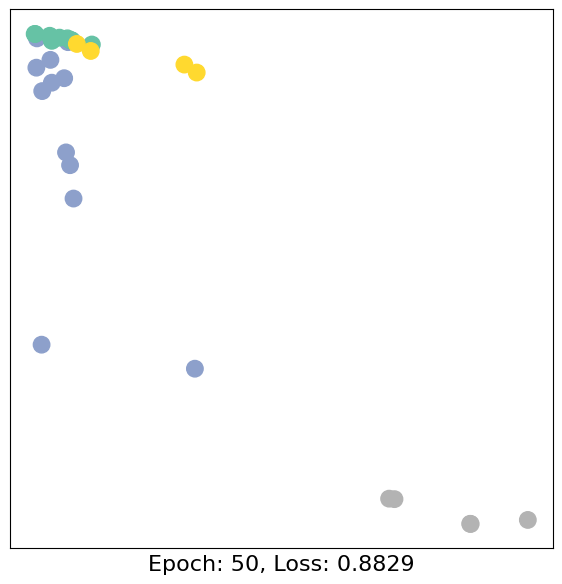

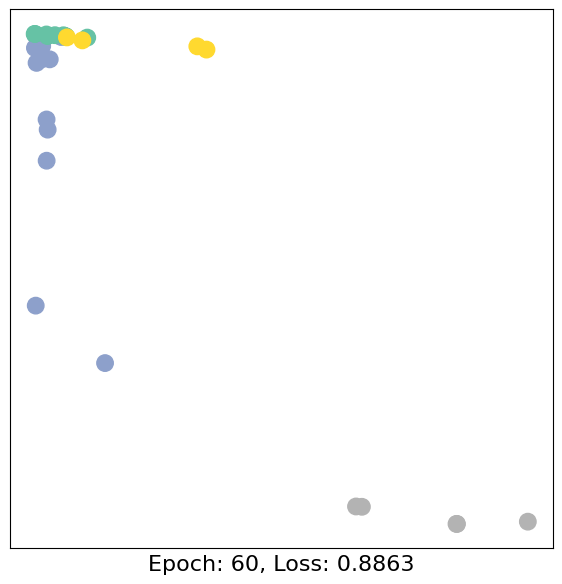

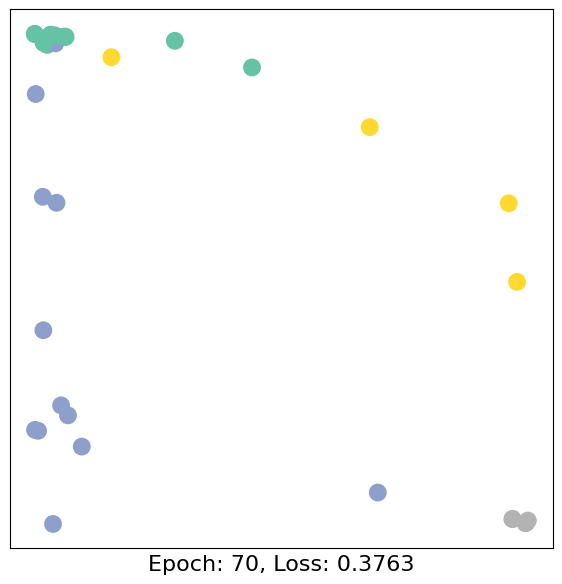

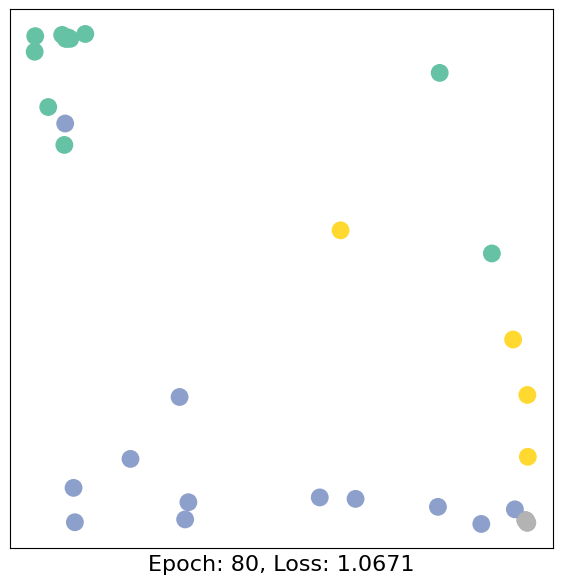

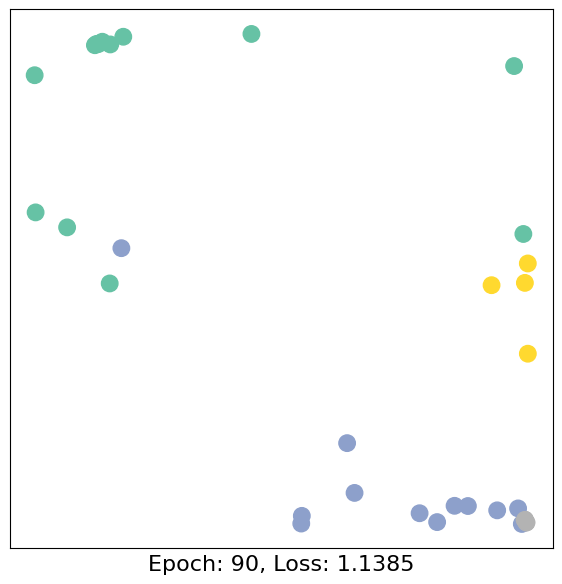

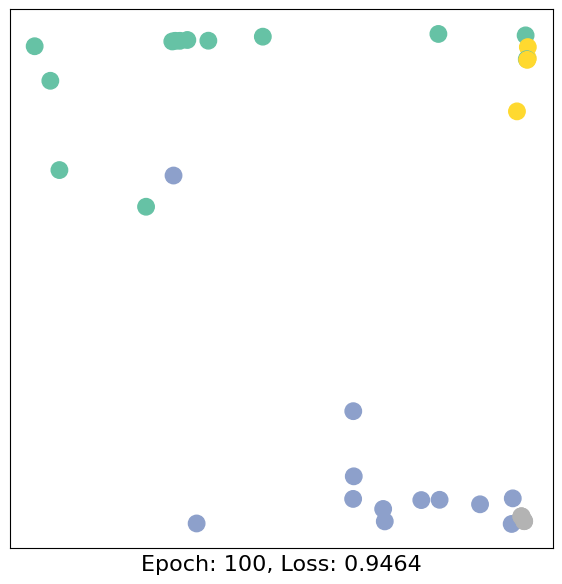

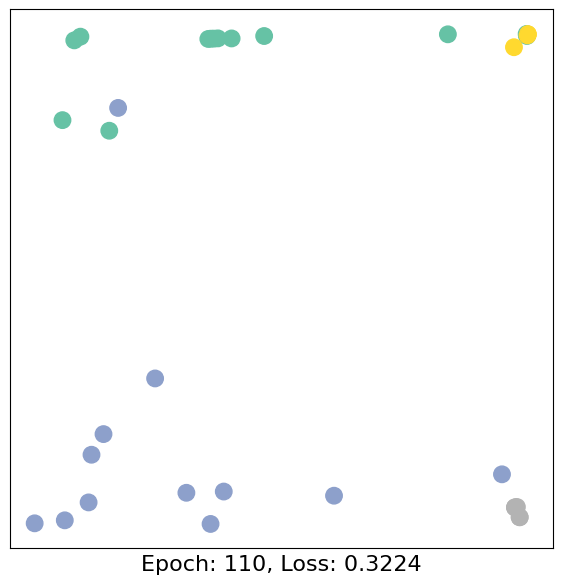

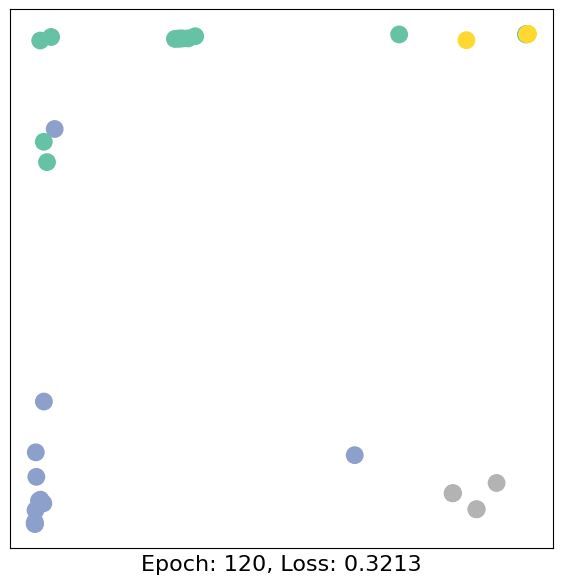

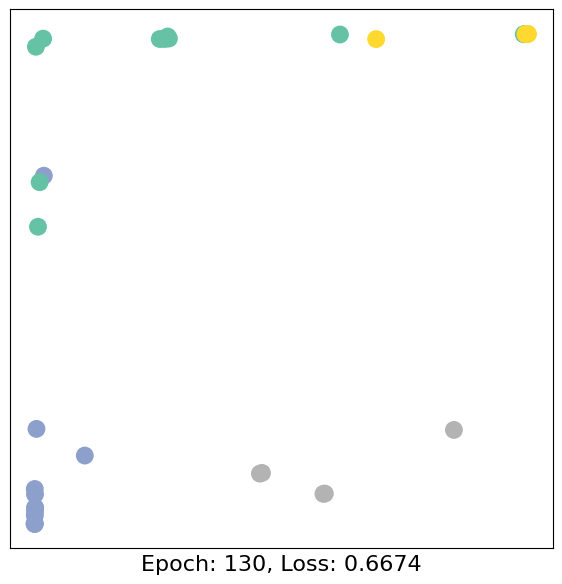

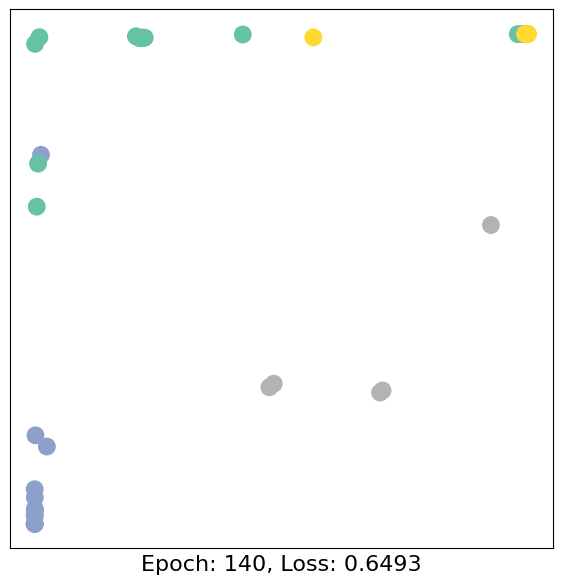

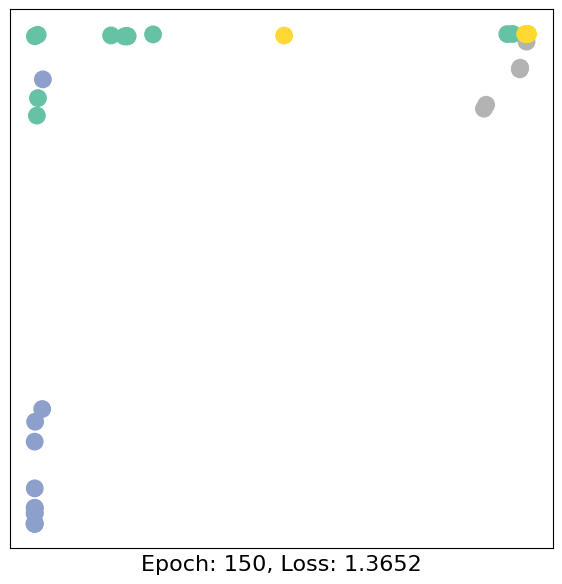

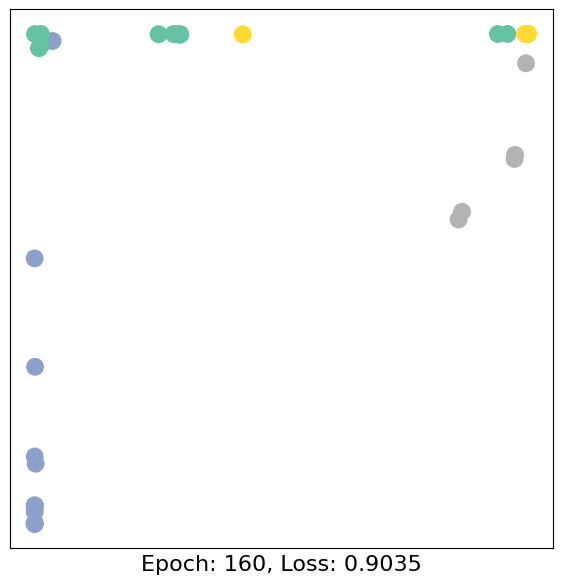

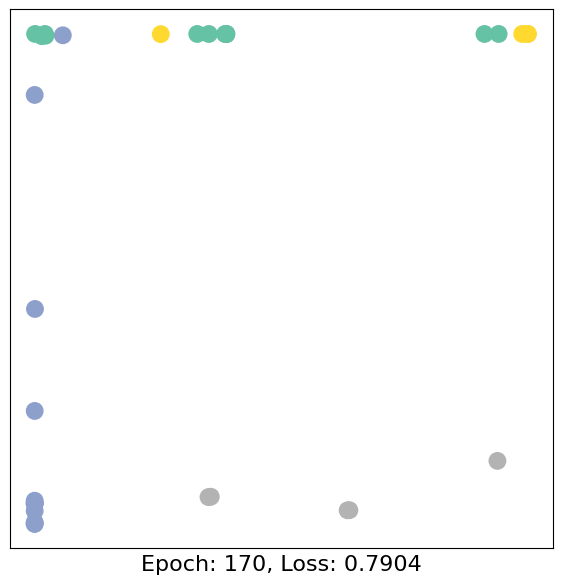

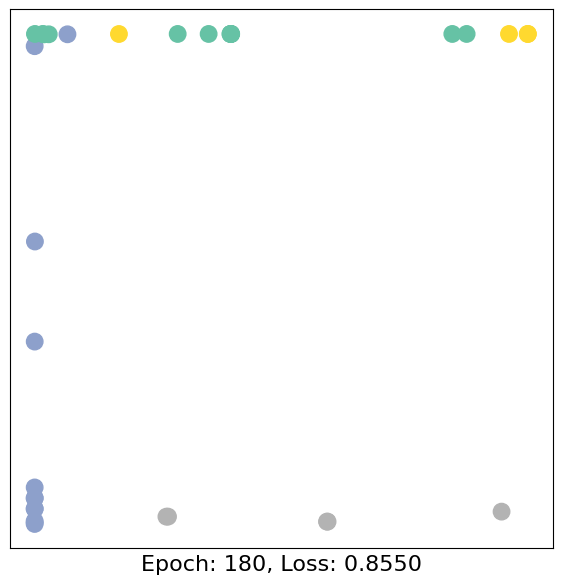

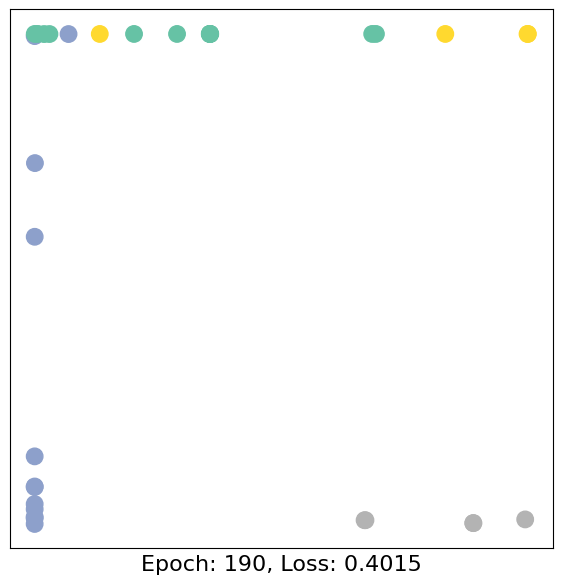

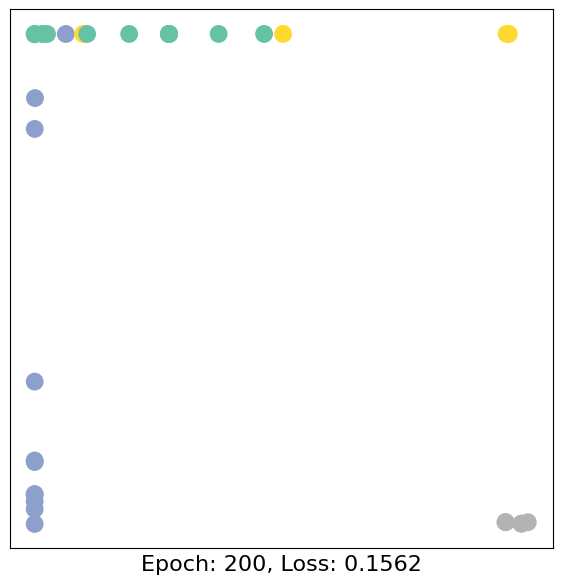

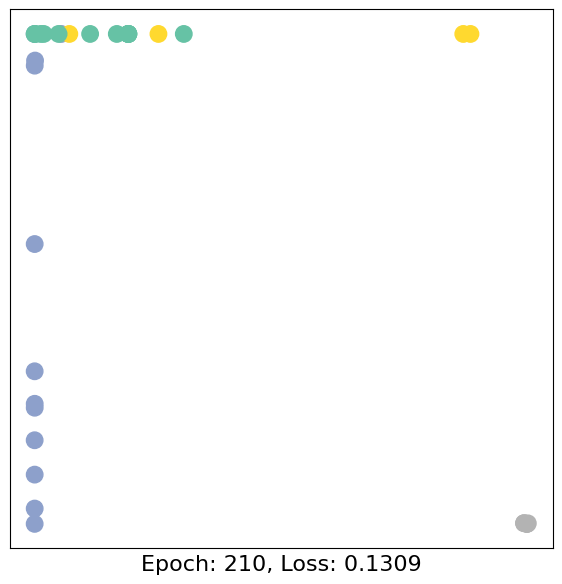

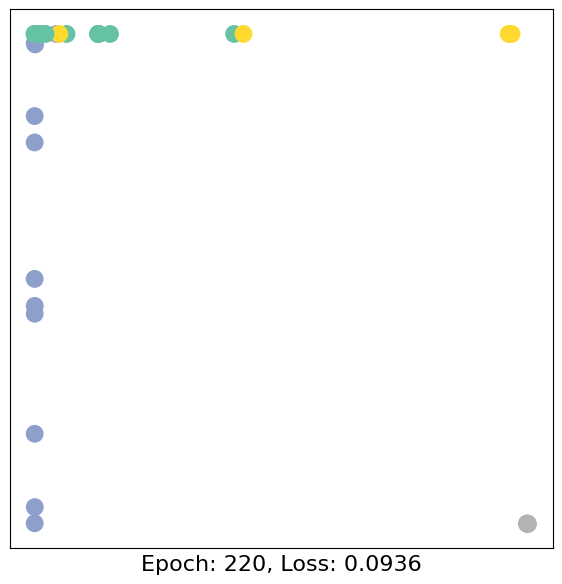

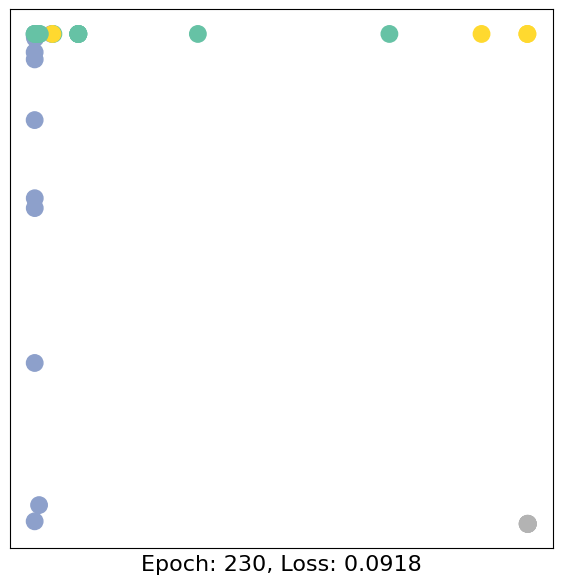

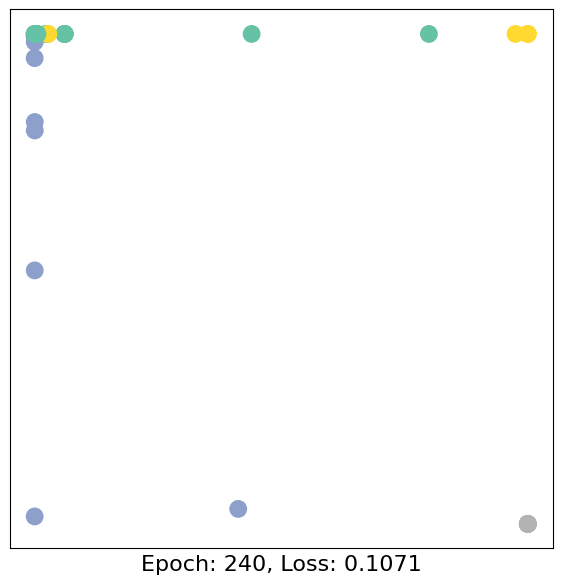

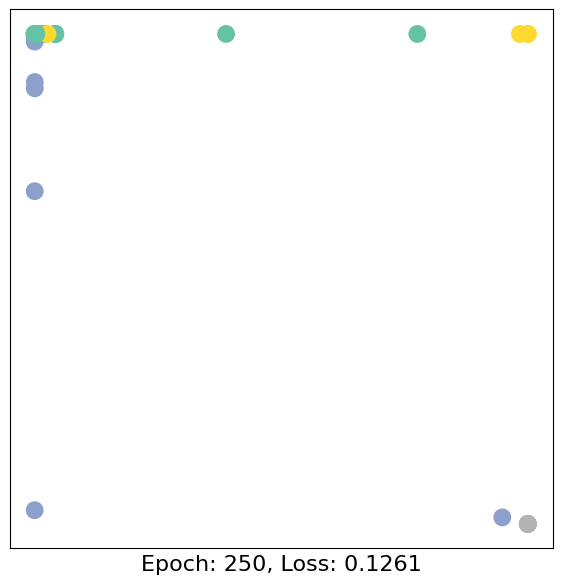

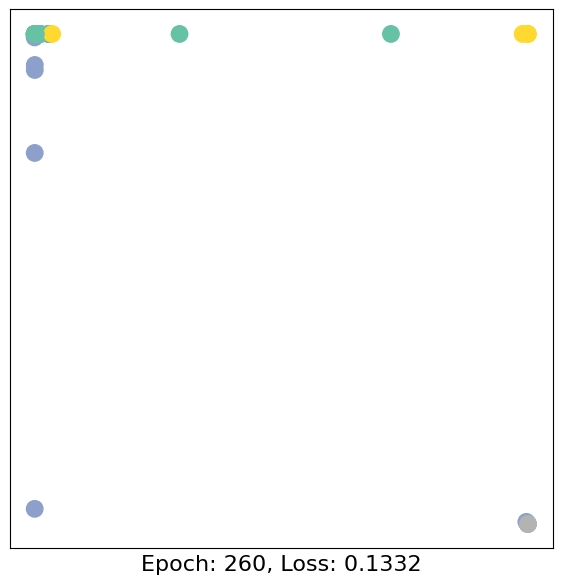

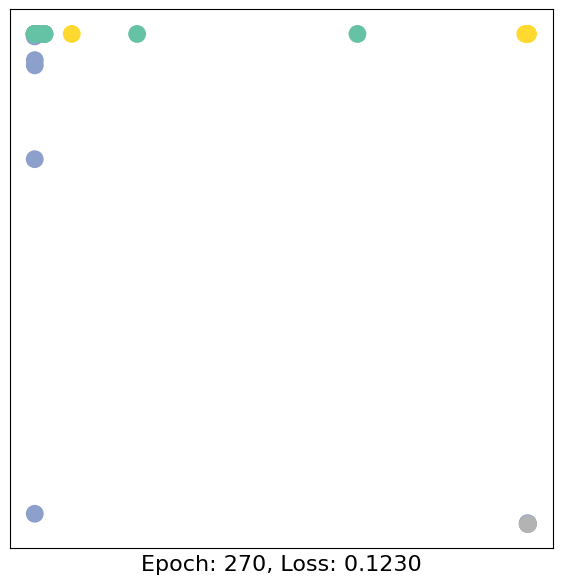

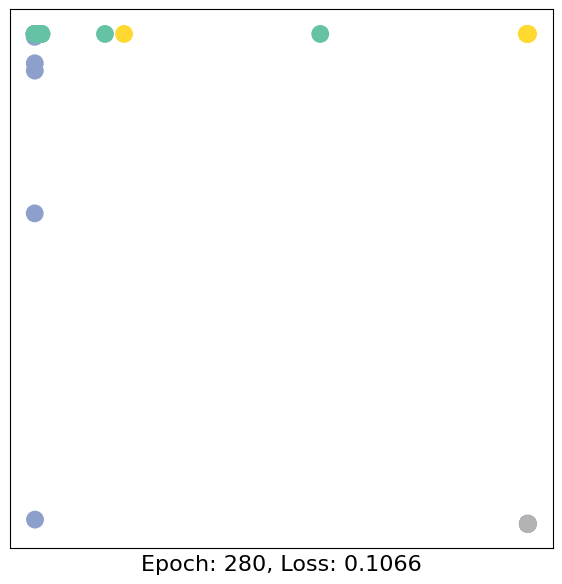

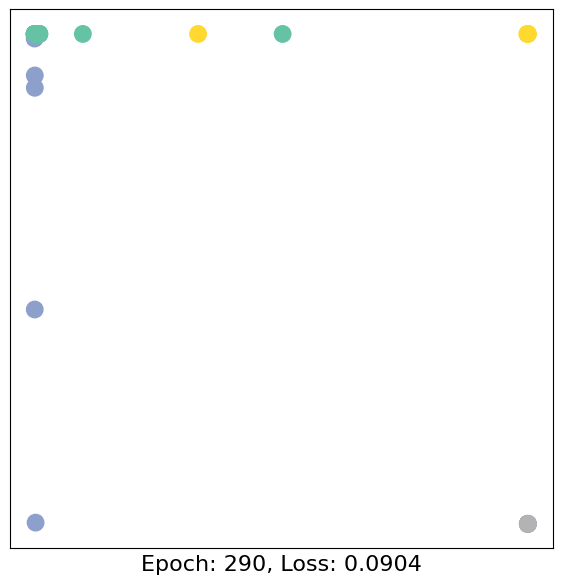

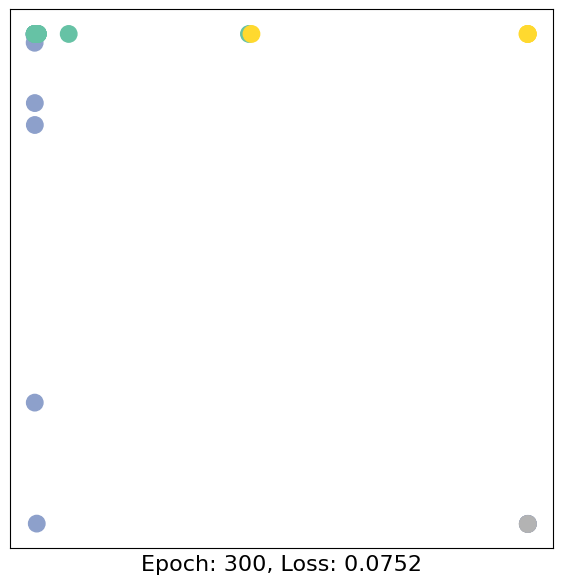

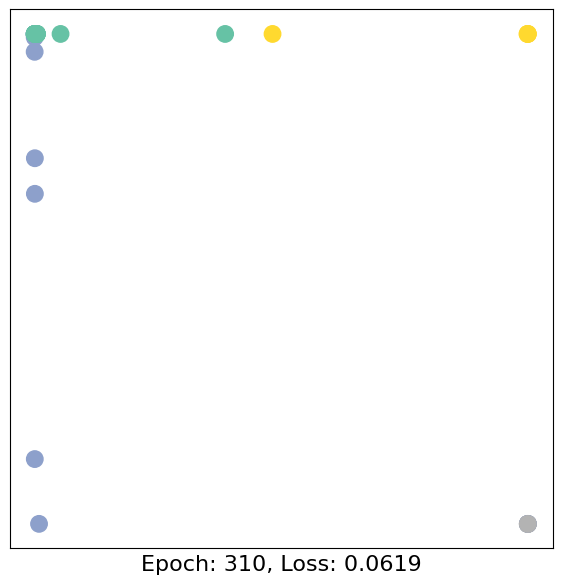

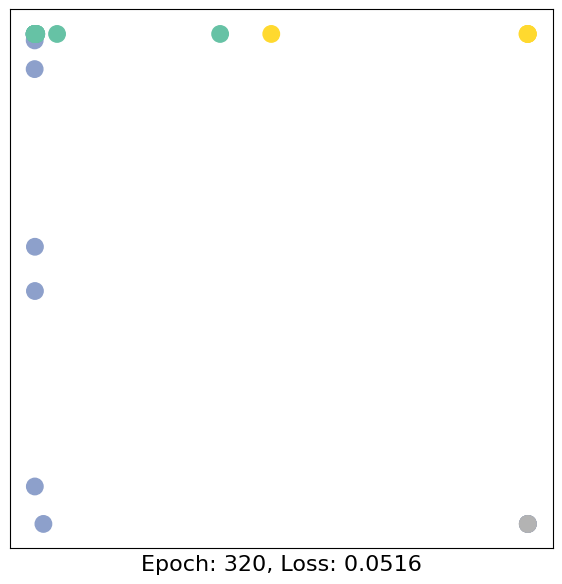

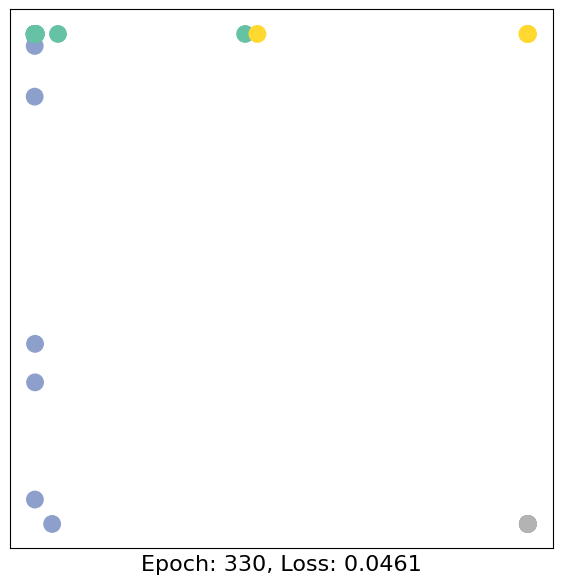

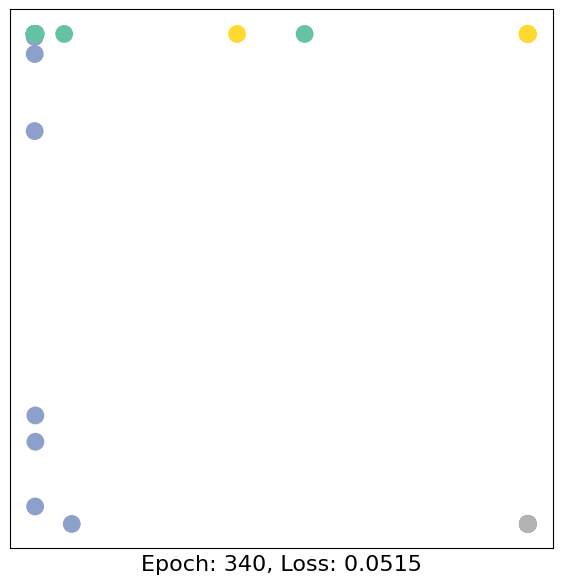

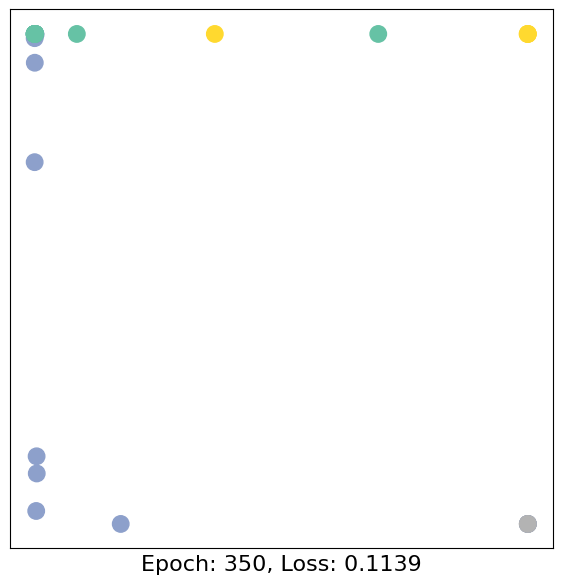

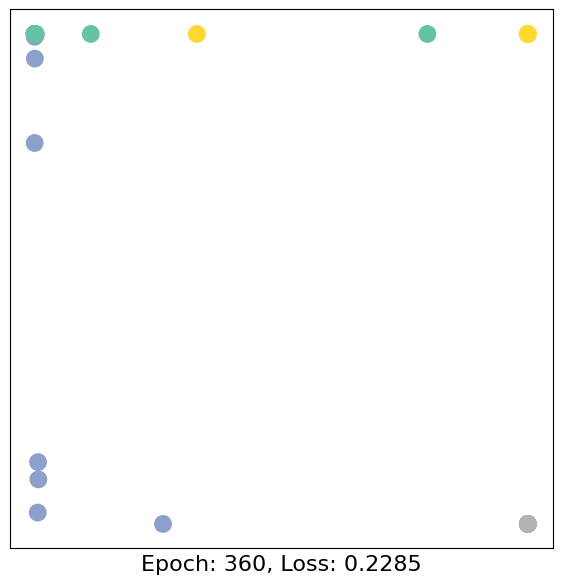

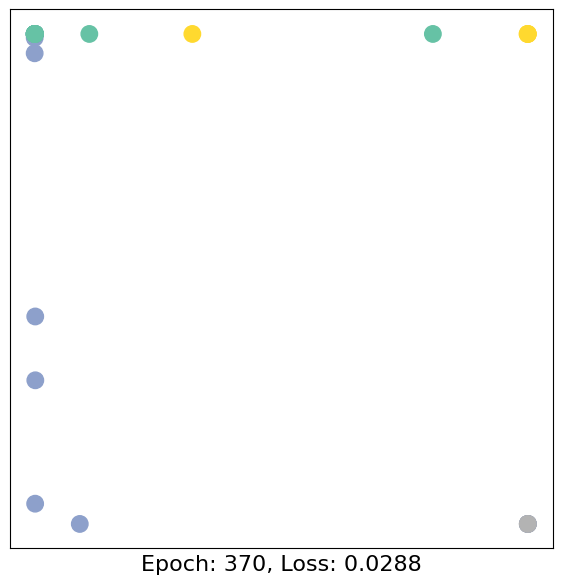

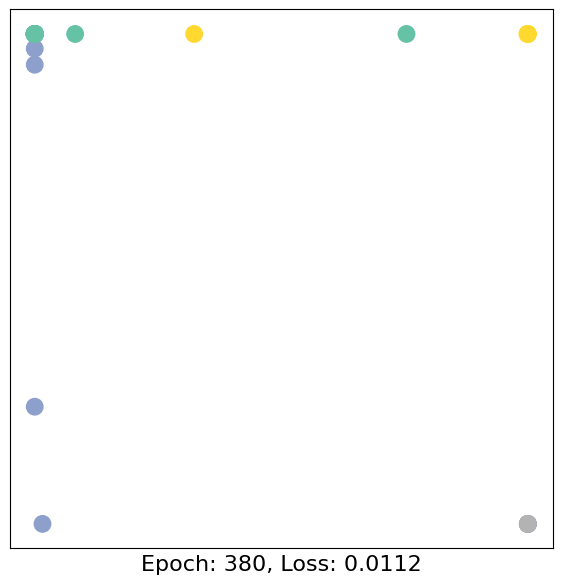

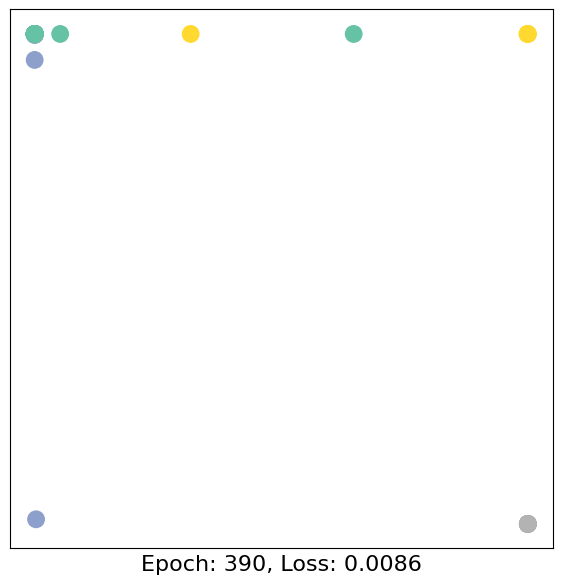

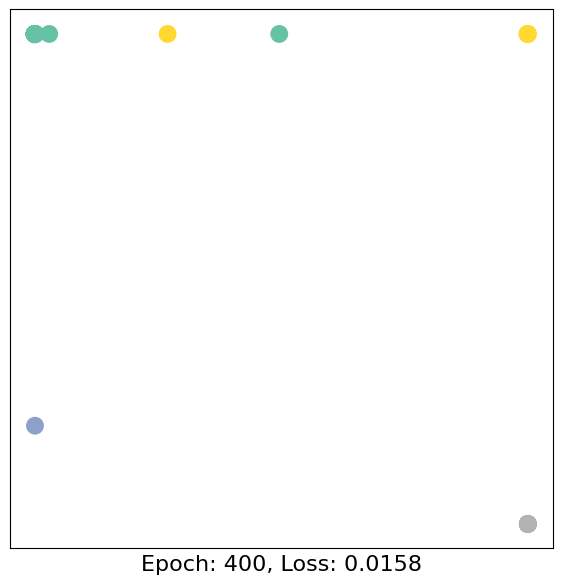

In [126]:
gcn = GCN(in_feats, out_feats).to(device)
g = g.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)


def train(g):
    optimizer
    out, h = gcn(g.x, g.edge_index)
    loss = loss_func(out[g.train_mask], g.y[g.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h


for e in range(401):
    loss, h = train(g)
    if e % 10 == 0:
        visualize_embedding(h, color=g.y.to("cpu"), epoch=e, loss=loss)

In [187]:
g = g.to("cpu")
gcn = gcn.to("cpu")
with torch.no_grad():

    logits, h = gcn(g.x, g.edge_index)
    out = logits.softmax(dim=1).argmax(1)

    train_acc = (g.y[g.train_mask] == out[g.train_mask]).float().mean().item()

    g.test_mask = ~g.train_mask
    test_acc = (g.y[g.test_mask] == out[g.test_mask]).float().mean().item()
    print("train acc: ", train_acc)
    print("test acc: ", test_acc)

train acc:  1.0
test acc:  0.6000000238418579
